In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [2]:
PATH_TO_DATA = "D:\\DSCourse\\KaggleCompetitions\\Data\\SamsungRecognitionData\\UCI_HAR_Dataset\\"
ALT_PATH_TO_DATA = "C:\\Users\\Виктория\\PycharmProjects\\TextCorrector\\Data\\SamsungRecognitionData\\UCI_HAR_Dataset\\UCI_HAR_Dataset\\"

X_train = np.loadtxt(f"{ALT_PATH_TO_DATA}train\\X_train.txt")
y_train = np.loadtxt(f"{ALT_PATH_TO_DATA}train\\y_train.txt").astype(int)

X_test = np.loadtxt(f"{ALT_PATH_TO_DATA}test\\X_test.txt")
y_test = np.loadtxt(f"{ALT_PATH_TO_DATA}test\\y_test.txt").astype(int)

In [3]:
print("X data dimensions:")
print(X_train.shape, X_test.shape, end="\n\n")

print("y data dimensions:")
print(y_train.shape, y_test.shape)

X data dimensions:
(7352, 561) (2947, 561)

y data dimensions:
(7352,) (2947,)


For clustering we don't need in vectors of answers. So we will work with merged train and test data.

In [4]:
X = np.concatenate((X_train, X_test), axis=0)
print(f"The shape of X data after nerging the X_train and X_test: {X.shape}")

y = np.concatenate((y_train, y_test), axis=0)
print(f"The shape of X data after nerging the X_train and X_test: {y.shape}")

The shape of X data after nerging the X_train and X_test: (10299, 561)
The shape of X data after nerging the X_train and X_test: (10299,)


In [5]:
np.unique(y_train)

array([1, 2, 3, 4, 5, 6])

These labels correspond to:
1 – walking
2 – walking upstairs
3 – walking downstairs
4 – sitting
5 – standing
6 – laying down

# Preprocessing

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
pca_test = PCA(n_components=X.shape[1]-1, random_state=17)
pca_test.fit(X_scaled)

PCA(n_components=560, random_state=17)

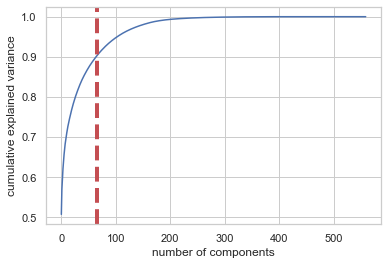

In [8]:
sns.set(style="whitegrid")
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=65, ymin=0, ymax=1)
#display(plt.show())

In [9]:
pca = PCA(n_components=65, random_state=17)
X_pca_scaled = pca.fit_transform(X_scaled)
print(f"After applying pca to scaed data the shape of X is: {X_pca_scaled.shape}")

After applying pca to scaed data the shape of X is: (10299, 65)


Visualization of new dataset with only two main komponents. It's explain only 51% of variance.

In [10]:
vis_pca = PCA(n_components=2, random_state=17)
X_vispca_scaled = vis_pca.fit_transform(X_scaled)

<AxesSubplot:>

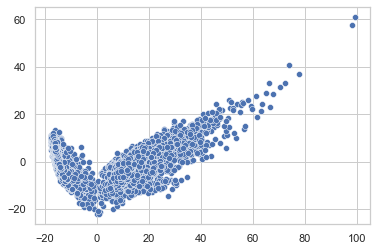

In [11]:
sns.scatterplot(x=X_vispca_scaled.T[0], y=X_vispca_scaled.T[1])

## Search the optimal amount of clusters

In [12]:
from sklearn.cluster import KMeans

In [14]:
class AmountOfClustersSearch:
    
    
    def __init__(self, clust_model, amount_of_clusters, train_data, param=None):
        self.models_params = {"KMeans": "inertia_", "AgglomerativeClustering": "distances_"}
        self.results = []
        
        if param and self.models_params[clust_model.__name__] == param:
            self.param = param
        elif clust_model.__name__ in self.models_params.keys():
            self.param = self.models_params[clust_model.__name__]
        else:
            raise ValueError(f"You need to specify the attribute for class {clust_model}")
            
        for n_clusters in amount_of_clusters:
            self.model = clust_model(n_clusters=n_clusters)
            self.model.fit(train_data)
            self.results.append({"n_clusters": n_clusters, "main_param": getattr(self.model, self.param)})
        self.results = pd.DataFrame(self.results)
        
        
    def show_elbow_graph(self, figsize=(8, 6), x_vline=5, ylim=None):
        plt.figure(figsize=figsize)
        sns.lineplot(data=results, x="n_clusters", y="main_param")
        plt.axvline(linewidth=4, color='r', linestyle = '--', x=x_vline)
        if ylim:
            plt.ylim(ylim)
                
                
    def show_differencies_graph(self, figsize=(8, 6), x_vline=5, ylim=None, xlim=None):
        
        if not "differensies" in self.results.columns:
            inertias = self.results["main_param"].tolist()
            differensies = [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
            differensies = list(map(lambda dif: round(dif, 2), differensies))
            self.results["differensies"] = [0] + differensies
            
        plt.figure(figsize=figsize)
        sns.lineplot(data=results, x="n_clusters", y="differensies")
        if ylim:
            plt.ylim(ylim)
        if xlim:
            plt.xlim(xlim)
        plt.axvline(linewidth=4, color='r', linestyle = '--', x=x_vline)

In [15]:
amount_of_clusters = list(range(1, 11)) # Let's start by checking only 10 clasters.
results = []
for n_clusters in amount_of_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_pca_scaled)
    results.append({"n_clusters": n_clusters, "inertia": kmeans.inertia_})
    
results = pd.DataFrame(results)

(1500000.0, 3500000.0)

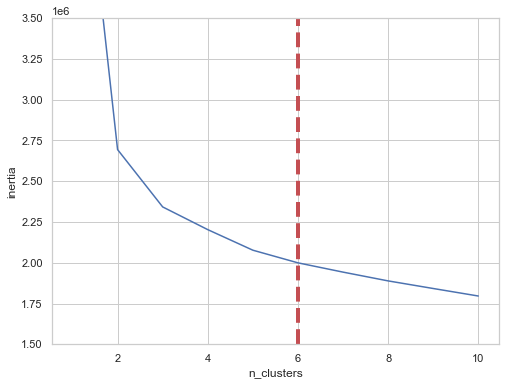

In [16]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x="n_clusters", y="inertia")
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6)
plt.ylim([1.5*10**6, 3.5*10**6])

In [17]:
inertias = results["inertia"].tolist()
differensies = [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
differensies = list(map(lambda dif: round(dif, 2), differensies))
results["differensies"] = [0] + differensies

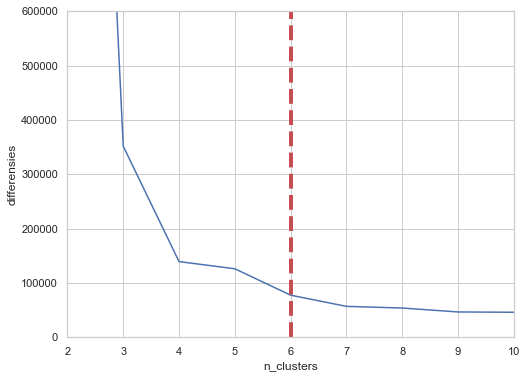

In [18]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x="n_clusters", y="differensies")
plt.xlim([2, 10])
plt.ylim([0, 0.6*10**6])
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6)

We can make a hypothesis that 4 is an optimal amount of clusters. But firstly lets try to separate objects into 6 clusters.
Because it's amount of answer's classes, so it's logically. 

In [19]:
log_kmeans = KMeans(n_clusters=6, random_state=17, n_init=100)
predictions = log_kmeans.fit_predict(X_pca_scaled)
vis_predictios = log_kmeans.fit_predict(X_vispca_scaled)

In [20]:
two_comp_data = pd.DataFrame(columns=["1_comp", "2_comp", "cluster"], 
                             data = np.hstack([X_vispca_scaled, vis_predictios.reshape(-1, 1)]))
pca_data = pd.DataFrame(columns=[f"{i}_comp" for i in range(1, 66)].append("cluster"), 
                             data = np.hstack([X_pca_scaled, predictions.reshape(-1, 1)]))

<AxesSubplot:xlabel='1_comp', ylabel='2_comp'>

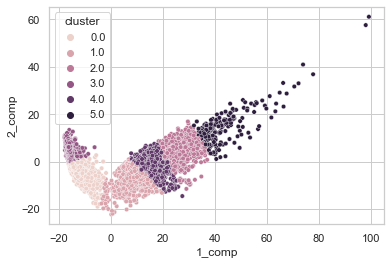

In [21]:
sns.scatterplot(data=two_comp_data, x="1_comp", y="2_comp", hue="cluster",s=20, cmap='viridis')

In [22]:
tab = pd.crosstab(y, predictions, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']

In [23]:
tab["max_amount"] = tab.loc[:, :"cluster6"].max(numeric_only=True, axis = 1)
tab["sep_procent"] = round(tab["max_amount"] / tab["all"] * 100, 2)
tab = tab.drop(columns=["max_amount"])
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all,sep_procent
walking,904,0,0,0,78,740,1722,52.50
going up the stairs,1242,0,2,0,5,295,1544,80.44
going down the stairs,320,0,0,0,196,890,1406,63.30
sitting,1,1235,450,91,0,0,1777,69.50
standing,0,1344,562,0,0,0,1906,70.51
laying,5,53,329,1557,0,0,1944,80.09
all,2472,2632,1343,1648,279,1925,10299,25.56


As we can see, 6 clusters, choosed by KMeans algorithm separate data not really well. Let's try AgglomerativeClustering

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
ag = AgglomerativeClustering(n_clusters=6)

In [26]:
ag_predictions = ag.fit_predict(X_pca_scaled)
ag_tab = pd.crosstab(y, ag_predictions, margins=True)
ag_tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
ag_tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
ag_tab["max_amount"] = ag_tab.loc[:, :"cluster6"].max(numeric_only=True, axis = 1)
ag_tab["sep_procent"] = round(ag_tab["max_amount"] / ag_tab["all"] * 100, 2)
ag_tab = ag_tab.drop(columns=["max_amount"])
ag_tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all,sep_procent
walking,225,1272,0,0,225,0,1722,73.87
going up the stairs,30,623,0,0,891,0,1544,57.71
going down the stairs,786,458,0,0,162,0,1406,55.90
sitting,0,0,503,13,0,1261,1777,70.96
standing,0,0,719,0,0,1187,1906,62.28
laying,0,0,57,1818,0,69,1944,93.52
all,1041,2353,1279,1831,1278,2517,10299,24.44


In [27]:
from sklearn.metrics import adjusted_rand_score

In [28]:
best_kmeans = KMeans(n_clusters=4, n_init=100)
best_predictions = best_kmeans.fit_predict(X_pca_scaled)

In [29]:
print(f"The ARI for kmeans with 6 ckusters: {adjusted_rand_score(y, predictions)}")
print(f"The ARI for AgglomerativeClustering with 6 ckusters: {adjusted_rand_score(y, ag_predictions)}")
print(f"The ARI for kmeans with 4 ckusters: {adjusted_rand_score(y, best_predictions)}")

The ARI for kmeans with 6 ckusters: 0.41967784566875505
The ARI for AgglomerativeClustering with 6 ckusters: 0.488010997684971
The ARI for kmeans with 4 ckusters: 0.2994290901310719


In [31]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"The shape of X_train_scaled: {X_train_scaled.shape}")
print(f"The shape of X_test_scaled: {X_test_scaled.shape}")

The shape of X_train_scaled: (7352, 561)
The shape of X_test_scaled: (2947, 561)


In [33]:
svc = LinearSVC(random_state=17)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}
gr_search = GridSearchCV(svc, svc_params, cv=3)

In [35]:
gr_search.fit(X_train_scaled, y_train)

C:\CondaProg\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\CondaProg\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\CondaProg\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\CondaProg\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\CondaProg\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\CondaProg\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\CondaProg\lib\site-packages\sklearn\s

GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [38]:
gr_search.best_params_, gr_search.best_score_

({'C': 0.1}, 0.9382506099134881)